In [1]:
from gbmbkgpy.utils.continuous_data import ContinuousData 
from gbmbkgpy.utils.external_prop import ExternalProps
from gbmbkgpy.point_source import PointSource
from gbmbkgpy.modeling.model import Model
from gbmbkgpy.modeling.source import Source, ContinuumSource, FlareSource, PointSource, SAASource
from gbmbkgpy.modeling.function import Function, ContinuumFunction
from gbmbkgpy.functions import (Solar_Flare, Solar_Continuum, SAA_Decay,
Magnetic_Continuum, Cosmic_Gamma_Ray_Background, Point_Source_Continuum)



from gbmbkgpy.io.package_data import get_path_of_data_dir, get_path_of_data_file
from gbmbkgpy.utils.progress_bar import progress_bar
from gbmbkgpy.io.plotting.step_plots import step_plot, slice_disjoint, disjoint_patch_plot

import scipy.interpolate as interpolate
import astropy.units as u
from gbmgeometry import GBMTime
import astropy.time as astro_time
import astropy.coordinates as coord
import astropy.units as u
import astropy.io.fits as fits
import numpy as np
import collections
import matplotlib.pyplot as plt
import math

In [2]:
cd = ContinuousData('/home/felix/Documents/projects/bachelor-thesis/data/ctime/150926/glg_ctime_n5_150926_v00.pha','/home/felix/Documents/projects/bachelor-thesis/data/poshist/glg_poshist_all_150926_v00.fit')
ep = ExternalProps('150926')

/home/felix/Documents/projects/bachelor-thesis/GBM-background-model/gbmbkgpy/utils/continuous_data.py:425: RuntimeWarning: invalid value encountered in sqrt
  np.tan(beta)) - np.cos(opening_ang) * np.arccos(np.tan(beta) / np.tan(opening_ang)) - (np.arctan2(
/home/felix/Documents/projects/bachelor-thesis/GBM-background-model/gbmbkgpy/utils/continuous_data.py:425: RuntimeWarning: invalid value encountered in arccos
  np.tan(beta)) - np.cos(opening_ang) * np.arccos(np.tan(beta) / np.tan(opening_ang)) - (np.arctan2(
/home/felix/Documents/projects/bachelor-thesis/GBM-background-model/gbmbkgpy/utils/continuous_data.py:433: RuntimeWarning: invalid value encountered in sqrt
  np.tan(beta_e)) - np.cos(theta) * np.arccos(np.tan(beta_e) / np.tan(theta)) - (
/home/felix/Documents/projects/bachelor-thesis/GBM-background-model/gbmbkgpy/utils/continuous_data.py:433: RuntimeWarning: invalid value encountered in arccos
  np.tan(beta_e)) - np.cos(theta) * np.arccos(np.tan(beta_e) / np.tan(theta)) - (
/h

# Point-Source Sources
ep.build_point_sources(cd)
PS_Continuum_dic = {}
PS_Sources_list = []

for ps in ep.point_sources.itervalues():
    PS_Continuum_dic[ps.name] = Point_Source_Continuum()
    PS_Continuum_dic[ps.name].set_interpolated_function(ps.separation_angle)

    PS_Sources_list.append(PointSource(ps.name, PS_Continuum_dic[ps.name]))

#add *PS_Sources_list to model constructor

In [ ]:
# SAA Decay Source
SAA_Decay_list = []
saa_n = 0

for time in cd.saa_mean_times:
    saa_n += 1
    saa_dec = SAA_Decay()
    saa_dec.set_saa_exit_time(np.array([time]))
    SAA_Decay_list.append(SAASource('saa_' + str(saa_n), saa_dec))

In [3]:
# Solar Continuum Source
sol_con = Solar_Continuum()
sol_con.set_interpolated_function(cd.sun_angle)
Source_Solar_Continuum = ContinuumSource('solar_continuum', sol_con)

In [4]:
# Magnetic Continuum Source
mag_con = Magnetic_Continuum()
mag_con.set_interpolated_function(ep.mc_l)
Source_Magnetic_Continuum = ContinuumSource('magnetic_continuum', mag_con)

In [ ]:
model = Model(Source_Solar_Continuum, Source_Magnetic_Continuum, *PS_Sources_list, *SAA_Decay_list)

# SUM of fluxes
sum_solar_con = 0.
sum_magnetic_con = 0.

    
with progress_bar(len(cd.time_bins[2:-2]),title='Calculating solar flux') as p:

    for bin in cd.time_bins[2:-2]:  
        sum_solar_con += Source_Solar_Continuum.get_flux(bin[0], bin[1])
        p.increase()
with progress_bar(len(cd.time_bins[2:-2]),title='Calculating magnetic flux') as p:

    for bin in cd.time_bins[2:-2]:  
        sum_magnetic_con += Source_Magnetic_Continuum.get_flux(bin[0], bin[1])
        p.increase()
        
print "Solar sum: {}".format(sum_solar_con)
print "Magnetic sum {}".format(sum_magnetic_con)

In [5]:
arr_solar_con = []
arr_solar_con_quad = []
arr_magnetic_con = []
arr_magnetic_con_quad = []

    
with progress_bar(len(cd.time_bins[2:-2]),title='Calculating solar flux') as p:

    for bin in cd.time_bins[2:-2]:  
        arr_solar_con.append(Source_Solar_Continuum.get_flux(bin[0], bin[1]))
        arr_solar_con_quad.append(Source_Solar_Continuum.get_flux_quad(bin[0], bin[1]))
        p.increase()
with progress_bar(len(cd.time_bins[2:-2]),title='Calculating magnetic flux') as p:

    for bin in cd.time_bins[2:-2]:  
        arr_magnetic_con.append(Source_Magnetic_Continuum.get_flux(bin[0], bin[1]))
        arr_magnetic_con_quad.append(Source_Magnetic_Continuum.get_flux_quad(bin[0], bin[1]))
        p.increase()

solar_con_interpolator = interpolate.interp1d(cd.mean_time[2:-2], arr_solar_con)
magnetic_con_interpolator = interpolate.interp1d(cd.mean_time[2:-2], arr_magnetic_con)

A Jupyter Widget

A Jupyter Widget

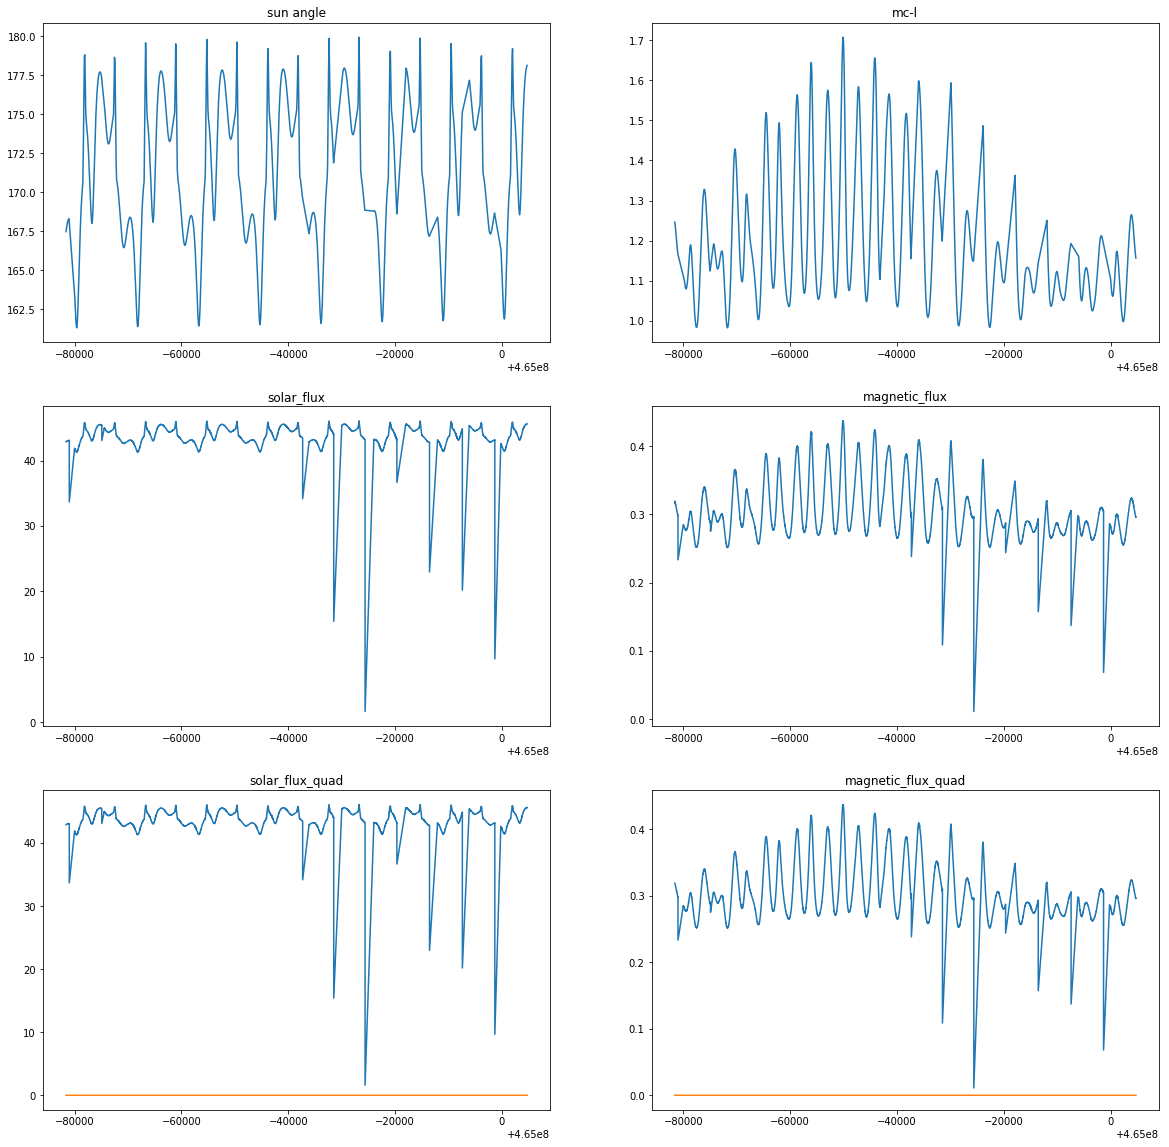

In [9]:
plt.figure(figsize=(20,20))

plt.subplot(321)
plt.plot(cd.mean_time[2:-2],  cd.sun_angle(cd.mean_time[2:-2]))
plt.title('sun angle')

plt.subplot(322)
plt.plot(cd.mean_time[2:-2],  ep.mc_l(cd.mean_time[2:-2]))
plt.title('mc-l')

plt.subplot(323)  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)
plt.plot(cd.mean_time[2:-2], solar_con_interpolator(cd.mean_time[2:-2]))
plt.title('solar_flux')

plt.subplot(324)
plt.plot(cd.mean_time[2:-2], magnetic_con_interpolator(cd.mean_time[2:-2]))
plt.title('magnetic_flux')

plt.subplot(325)  #sublot(Anzahl Zeilen Anzahl Spalten Bild Nummer)
plt.plot(cd.mean_time[2:-2], arr_solar_con_quad)
plt.title('solar_flux_quad')

plt.subplot(326)
plt.plot(cd.mean_time[2:-2],  arr_magnetic_con_quad)
plt.title('magnetic_flux_quad')

plt.show()

In [ ]:
def integrate_sims(fkt, a, b):
    return (b-a)/6*(fkt(a)+4*fkt((a+b)/2)+fkt(b))


In [ ]:
integrate_sims(cd.sun_angle, min_met, min_met+bin_step)

In [ ]:
point=ep.point_sources['1E1740-29']
def plot():   
    fig, ax = plt.subplots()

    ax.plot(cd.mean_time[:-1],point.separation_angle(cd.mean_time[:-1]))

    ax.set_xlabel('MET')
    ax.set_ylabel('Angle (deg)')
    return fig
plot()